In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\91889\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv', nrows=5000)
resource_data = pd.read_csv('resources.csv')
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]


In [3]:
project_data.isnull().sum()

Unnamed: 0                                         0
id                                                 0
teacher_id                                         0
teacher_prefix                                     0
school_state                                       0
project_submitted_datetime                         0
project_grade_category                             0
project_subject_categories                         0
project_subject_subcategories                      0
project_title                                      0
project_essay_1                                    0
project_essay_2                                    0
project_essay_3                                 4843
project_essay_4                                 4843
project_resource_summary                           0
teacher_number_of_previously_posted_projects       0
project_is_approved                                0
dtype: int64

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (5000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)



Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   

  project_subject_categories project_subject_subcategories  \
0        Literacy & Language                 ESL, Literacy   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   

   teacher_number_of_previously_posted_projects  
0                                             0

## 1.3 preprocessing of `project_subject_categories`


In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [7]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects              clean_categories  
0                                             0             Literacy_Language  
1                                             7  History_Civics Health_Sports

## 1.3 preprocessing of `project_subject_subcategories`

In [8]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [9]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects              clean_categories  \
0                                             0             Literacy_Language   
1                                             7  History_Civics Health_Sports   

            clean_subcategories  
0                  ESL Literacy  
1  Civics_Government TeamSports

In [10]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades_PreK_2   
1           FL           25-10-2016 09:22             Grades_6_8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects              clean_categories  \
0                                             0             Literacy_Language   
1                                             7  History_Civics Health_Sports   

            clean_subcategories  
0                  ESL Literacy  
1  Civics_Government TeamSports

## 1.4 Merging datasets

In [11]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(5)

id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8

In [12]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [13]:
project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades_PreK_2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   

   teacher_number_of_previously_posted_projects   clean_categories  \
0                                             0  Literacy_Language   

  clean_subcategories  price  quantity  
0        ESL Literacy  154.6        23

## 1.3 Text preprocessing

In [14]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [15]:
# we get the cost of the project using resource.csv file
resource_data.head(5)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [18]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1066.02it/s]


In [19]:
project_data["essay"] = preprocessed_essays

project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades_PreK_2   
1           FL           25-10-2016 09:22             Grades_6_8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects              clean_categories  \
0                                             0             Literacy_Language   
1                                             7  History_Civics Health_Sports   

            clean_subcategories  price  quantity  \
0                  ESL Literacy  154.6        23   
1  Civics_Government TeamSports  299.0         1   

                                               essay  
0  my students english learners working english s...  
1  our students arrive school eager learn they po...

In [20]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    title = decontracted(sentance)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 23224.76it/s]


In [21]:
project_data["project_title"] = preprocessed_titles

project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades_PreK_2   
1           FL           25-10-2016 09:22             Grades_6_8   

                               project_title  \
0  educational support english learners home   
1           wanted projector hungry learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects              clean_categories  \
0                                             0             Literacy_Language   
1                                             7  History_Civics Health_Sports   

            clean_subcategories  price  quantity  \
0                  ESL Literacy  154.6        23   
1  Civics_Government TeamSports  299.0         1   

                                               essay  
0  my students english learners working english s...  
1  our students arrive school eager learn they po...

In [22]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for essay in project_data:
    essay.lower()
    ss = sid.polarity_scores(essay)

    for k in ss:
        project_data['compound_rate'] = ss['compound']
        project_data['pos_rate']= ss['pos']
        project_data['neu_rate']= ss['neu']
        project_data['neg_rate']= ss['neg']
                
print(project_data['compound_rate'].shape)
project_data.head(2)

C:\Users\91889\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91889\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
(5000,)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades_PreK_2   
1           FL           25-10-2016 09:22             Grades_6_8   

                               project_title  \
0  educational support english learners home   
1           wanted projector hungry learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2    ...     \
0  \"The limits of your language are the limits o...    ...      
1  The projector we need for our school is very c...    ...      

  teacher_number_of_previously_posted_projects              clean_categories  \
0                                            0             Literacy_Language   
1                                            7  History_Civics Health_Sports   

            clean_subcategories  price quantity  \
0                  ESL Literacy  154.6       23   
1  Civics_Government TeamSports  299.0        1   

                                               essay  compound_rate  pos_rate  \
0  my students english learners working english s...            0.0       0.0   
1  our students arrive school eager learn they po...            0.0       0.0   

  neu_rate  neg_rate  
0      1.0       0.0  
1      1.0       0.0  

[2 rows x 23 columns]

In [23]:
 project_data['essay_n_words'] = project_data['essay'].apply(lambda row: len(row.split(" ")))

## 1.5 Sorting according to date

In [24]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
3287      159755  p147002  6ada7036aeb258d3653589d1f2a5b815           Mrs.   
2169       39017  p106634  fff2f15e91907f336d71e314b721d109            Ms.   

     school_state                Date project_grade_category  \
3287           CA 2016-01-05 02:02:00             Grades_3_5   
2169           MS 2016-01-05 15:00:00             Grades_6_8   

                                          project_title  \
3287                               multimedia apps game   
2169  empowering students through art glass panel po...   

                                        project_essay_1  \
3287  My students need new ways to learn. Research i...   
2169  \"What the poet sees in art and puts into word...   

                                        project_essay_2      ...        \
3287  My students are elementary students in kinderg...      ...         
2169  My students are intellectually gifted, but man...      ...         

                    clean_categories            clean_subcategories   price  \
3287  Literacy_Language SpecialNeeds          Literacy SpecialNeeds  157.91   
2169    Literacy_Language Music_Arts  Literature_Writing VisualArts   34.17   

      quantity                                              essay  \
3287         5  my students need new ways learn research indic...   
2169        29  what poet sees art puts words transform image ...   

     compound_rate  pos_rate  neu_rate neg_rate  essay_n_words  
3287           0.0       0.0       1.0      0.0             97  
2169           0.0       0.0       1.0      0.0            165  

[2 rows x 24 columns]

In [25]:
project_data["project_title"] = preprocessed_titles
project_data['title_n_words'] = project_data['project_title'].apply(lambda row: len(row.split(" ")))
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
3287      159755  p147002  6ada7036aeb258d3653589d1f2a5b815           Mrs.   
2169       39017  p106634  fff2f15e91907f336d71e314b721d109            Ms.   

     school_state                Date project_grade_category  \
3287           CA 2016-01-05 02:02:00             Grades_3_5   
2169           MS 2016-01-05 15:00:00             Grades_6_8   

                                  project_title  \
3287  educational support english learners home   
2169           wanted projector hungry learners   

                                        project_essay_1  \
3287  My students need new ways to learn. Research i...   
2169  \"What the poet sees in art and puts into word...   

                                        project_essay_2      ...        \
3287  My students are elementary students in kinderg...      ...         
2169  My students are intellectually gifted, but man...      ...         

                clean_subcategories   price quantity  \
3287          Literacy SpecialNeeds  157.91        5   
2169  Literature_Writing VisualArts   34.17       29   

                                                  essay compound_rate  \
3287  my students need new ways learn research indic...           0.0   
2169  what poet sees art puts words transform image ...           0.0   

     pos_rate  neu_rate  neg_rate essay_n_words  title_n_words  
3287      0.0       1.0       0.0            97              5  
2169      0.0       1.0       0.0           165              4  

[2 rows x 25 columns]

In [26]:
X=project_data

## 1.6 Splitting data

In [27]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
  

In [28]:
print(X.shape)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)


(5000, 25)
(2244, 25)
(1106, 25)
(1650, 25)
(5000,)
(2244,)
(1106,)
(1650,)


we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [29]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Assignment 7: SVM

<ol>
    <li><strong>[Task-1] Apply Support Vector Machines(SGDClassifier with hinge loss: Linear SVM) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning
        </ul>
            </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply the Support Vector Machines on these features by finding the best hyper paramter as suggested in step 2 and step 3</strong>
        <ul>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
                <li><strong>Apply <a href='http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html'>TruncatedSVD</a> on <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a> of essay text, choose the number of components (`n_components`) using <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/pca-code-example-using-non-visualization/'>elbow method</a></strong> : numerical data</li>
            </ul>
         <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Support Vector Machines </h1>

<h2>2.1 Make Data Model Ready: encoding numerical, categorical features</h2>

In [30]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
categories_ohe_train = vectorizer.fit_transform(X_train['clean_categories'].values)
categories_ohe_cv = vectorizer.transform(X_cv['clean_categories'].values)
categories_ohe_test = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(categories_ohe_train.shape, y_train.shape)
print(categories_ohe_cv.shape, y_cv.shape)
print(categories_ohe_test.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 9) (2244,)
(1106, 9) (1106,)
(1650, 9) (1650,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
subcategories_ohe_train = vectorizer.fit_transform(X_train['clean_subcategories'].values)
subcategories_ohe_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
subcategories_ohe_test = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(subcategories_ohe_train.shape, y_train.shape)
print(subcategories_ohe_cv.shape, y_cv.shape)
print(subcategories_ohe_test.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 30) (2244,)
(1106, 30) (1106,)
(1650, 30) (1650,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [32]:
#vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
X_train_state_ohe = vectorizer.fit_transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 50) (2244,)
(1106, 50) (1106,)
(1650, 50) (1650,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'wa', 'wi', 'wv', 'wy']


In [33]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.fit_transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 4) (2244,)
(1106, 4) (1106,)
(1650, 4) (1650,)
['mr', 'mrs', 'ms', 'teacher']


In [34]:
X_train['project_grade_category'].head(20)

4509    Grades_PreK_2
2646       Grades_3_5
2628    Grades_PreK_2
2292      Grades_9_12
1400    Grades_PreK_2
1008    Grades_PreK_2
1029       Grades_3_5
4952       Grades_3_5
2454    Grades_PreK_2
1893    Grades_PreK_2
291     Grades_PreK_2
3767    Grades_PreK_2
385        Grades_3_5
4647       Grades_6_8
3901    Grades_PreK_2
4793       Grades_3_5
1605       Grades_3_5
4631    Grades_PreK_2
2665    Grades_PreK_2
3489    Grades_PreK_2
Name: project_grade_category, dtype: object

In [35]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 4) (2244,)
(1106, 4) (1106,)
(1650, 4) (1650,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h2>2.2 Make Data Model Ready: encoding eassay, and project_title</h2>

In [36]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.fit_transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

                                        
print("After BOW vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


(2244, 25) (2244,)
(1106, 25) (1106,)
(1650, 25) (1650,)
After BOW vectorizations
(2244, 6877) (2244,)
(1106, 6877) (1106,)
(1650, 6877) (1650,)


In [37]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.fit_transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

                                        
print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)


(2244, 25) (2244,)
(1106, 25) (1106,)
(1650, 25) (1650,)
After vectorizations
(2244, 203) (2244,)
(1106, 203) (1106,)
(1650, 203) (1650,)


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After TFIDF vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


After TFIDF vectorizations
(2244, 6877) (2244,)
(1106, 6877) (1106,)
(1650, 6877) (1650,)


In [39]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

X_train_title_tfidf = vectorizer.fit_transform(X_train['project_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print("After TFIDF vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

After TFIDF vectorizations
(2244, 203) (2244,)
(1106, 203) (1106,)
(1650, 203) (1650,)


In [40]:
# average Word2Vec
# compute average word2vec for each review.
def w2v(data) :
    avg_w2v_vectors= []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    
    print(len(avg_w2v_vectors))
    print(len(avg_w2v_vectors[0]))

X_train_essay_avg_w2v = w2v(X_train['essay'])
X_cv_essay_avg_w2v = w2v(X_cv['essay'])
X_test_essay_avg_w2v = w2v(X_test['essay'])
X_train_title_avg_w2v = w2v(X_train['project_title'])
X_cv_title_avg_w2v = w2v(X_cv['project_title'])
X_test_title_avg_w2v = w2v(X_test['project_title'])




100%|████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:01<00:00, 2113.86it/s]


2244
300


100%|████████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 2054.79it/s]


1106
300


100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 1814.82it/s]


1650
300


100%|███████████████████████████████████████████████████████████████████████████| 2244/2244 [00:00<00:00, 40739.55it/s]


2244
300


100%|███████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 39875.70it/s]


1106
300


100%|███████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 39620.78it/s]


1650
300


In [41]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [42]:
def tfidf_w2v(data):# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(X_train['essay'])
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(X_train['essay']): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    
X_train_essay_tfidf_w2v = w2v(X_train['essay'])
X_test_essay_tfidf_w2v = w2v(X_test['essay'])
X_cv_essay_tfidf_w2v = w2v(X_cv['essay'])
X_train_title_tfidf_w2v = w2v(X_train['project_title'])
X_cv_title_tfidf_w2v = w2v(X_cv['project_title'])
X_test_title_tfidf_w2v = w2v(X_test['project_title'])




100%|████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:01<00:00, 1797.96it/s]


2244
300


100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 1777.16it/s]


1650
300


100%|████████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 1847.75it/s]


1106
300


100%|███████████████████████████████████████████████████████████████████████████| 2244/2244 [00:00<00:00, 27156.21it/s]


2244
300


100%|███████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 49600.11it/s]


1106
300


100%|███████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 44285.33it/s]


1650
300


## 2.3 Normalizing the numerical features

In [43]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacherno_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_teacherno_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacherno_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_teacherno_norm.shape, y_train.shape)
print(X_cv_teacherno_norm.shape, y_cv.shape)
print(X_test_teacherno_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(2244, 1) (2244,)
(1106, 1) (1106,)
(1650, 1) (1650,)
After vectorizations
(2244, 1) (2244,)
(1106, 1) (1106,)
(1650, 1) (1650,)
After vectorizations
(2244, 1) (2244,)
(1106, 1) (1106,)
(1650, 1) (1650,)


In [44]:
normalizer.fit(X_train['essay_n_words'].values.reshape(-1,1))

X_train_essaywords_norm = normalizer.transform(X_train['essay_n_words'].values.reshape(-1,1))
X_cv_essaywords_norm = normalizer.transform(X_cv['essay_n_words'].values.reshape(-1,1))
X_test_essaywords_norm = normalizer.transform(X_test['essay_n_words'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_essaywords_norm.shape, y_train.shape)
print(X_train_essaywords_norm.shape, y_cv.shape)
print(X_train_essaywords_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['title_n_words'].values.reshape(-1,1))

X_train_titleno_norm = normalizer.transform(X_train['title_n_words'].values.reshape(-1,1))
X_cv_titleno_norm = normalizer.transform(X_cv['title_n_words'].values.reshape(-1,1))
X_test_titleno_norm = normalizer.transform(X_test['title_n_words'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_titleno_norm.shape, y_train.shape)
print(X_train_titleno_norm.shape, y_cv.shape)
print(X_train_titleno_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(2244, 1) (2244,)
(2244, 1) (1106,)
(2244, 1) (1650,)
After vectorizations
(2244, 1) (2244,)
(2244, 1) (1106,)
(2244, 1) (1650,)


In [45]:
normalizer.fit(X_train['compound_rate'].values.reshape(-1,1))

X_train_compoundr_norm = normalizer.transform(X_train['compound_rate'].values.reshape(-1,1))
X_cv_compoundr_norm = normalizer.transform(X_cv['compound_rate'].values.reshape(-1,1))
X_test_compoundr_norm = normalizer.transform(X_test['compound_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_compoundr_norm.shape, y_train.shape)
print(X_cv_compoundr_norm.shape, y_cv.shape)
print(X_cv_compoundr_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['pos_rate'].values.reshape(-1,1))

X_train_posr_norm = normalizer.transform(X_train['pos_rate'].values.reshape(-1,1))
X_cv_posr_norm = normalizer.transform(X_cv['pos_rate'].values.reshape(-1,1))
X_test_posr_norm = normalizer.transform(X_test['pos_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_posr_norm.shape, y_train.shape)
print(X_train_posr_norm.shape, y_cv.shape)
print(X_train_posr_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['neu_rate'].values.reshape(-1,1))

X_train_neur_norm = normalizer.transform(X_train['neu_rate'].values.reshape(-1,1))
X_cv_neur_norm = normalizer.transform(X_cv['neu_rate'].values.reshape(-1,1))
X_test_neur_norm = normalizer.transform(X_test['neu_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neur_norm.shape, y_train.shape)
print(X_train_neur_norm.shape, y_cv.shape)
print(X_train_neur_norm.shape, y_test.shape)
print("="*100)

normalizer.fit(X_train['neg_rate'].values.reshape(-1,1))

X_train_negr_norm = normalizer.transform(X_train['neg_rate'].values.reshape(-1,1))
X_cv_negr_norm = normalizer.transform(X_cv['neg_rate'].values.reshape(-1,1))
X_test_negr_norm = normalizer.transform(X_test['neg_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_negr_norm.shape, y_train.shape)
print(X_train_negr_norm.shape, y_cv.shape)
print(X_train_negr_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(2244, 1) (2244,)
(1106, 1) (1106,)
(1106, 1) (1650,)
After vectorizations
(2244, 1) (2244,)
(2244, 1) (1106,)
(2244, 1) (1650,)
After vectorizations
(2244, 1) (2244,)
(2244, 1) (1106,)
(2244, 1) (1650,)
After vectorizations
(2244, 1) (2244,)
(2244, 1) (1106,)
(2244, 1) (1650,)


# 2.4 Applying SVM

### 2.4.1 Applying Support Vector Machines on BOW,<font color='red'> SET 1</font>

In [46]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_bow, X_train_essay_bow, X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train)).tocsr()
X_cr = hstack((X_cv_title_bow, X_cv_essay_bow, X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv)).tocsr()
X_te = hstack((X_test_title_bow, X_test_essay_bow, X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 7177) (2244,)
(1106, 7177) (1106,)
(1650, 7177) (1650,)


### Hyper parameter Tuning

In [47]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


clf = SGDClassifier(loss='hinge', class_weight = 'balanced')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
text_clf = calibrated_clf.fit(X_tr, y_train)

preds_train = text_clf.predict_proba(X_tr)    
preds_test = text_clf.predict_proba(X_cr)

y_train_pred = preds_train[:,1]
y_cv_pred = preds_test[:,1]

print(roc_auc_score(y_train,y_train_pred))
print(roc_auc_score(y_cv, y_cv_pred))
print(roc_auc_score(y_train,y_train_pred) - roc_auc_score(y_cv, y_cv_pred))


0.018077308588681652
0.5058192771845181
-0.48774196859583646


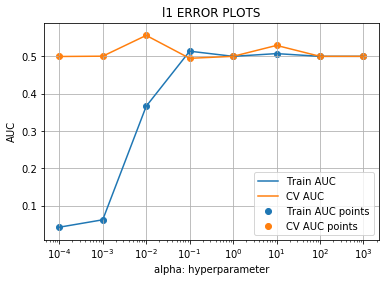

In [48]:
alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l1', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l1 ERROR PLOTS")
plt.grid()
plt.show()
    


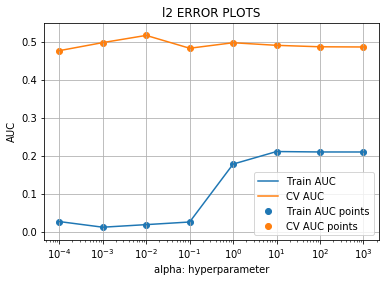

In [49]:
alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l2', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l2 ERROR PLOTS")
plt.grid()
plt.show()

In [50]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_alpha = 10 ** -1
best_penalty = 'l1'

In [51]:
print(X_tr.shape)
print(X_te.shape)
print(y_train.shape)



(2244, 7177)
(1650, 7177)
(2244,)


In [52]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


clf = linear_model.SGDClassifier(loss='hinge', alpha = best_alpha, penalty= best_penalty, class_weight = 'balanced')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
text_clf = calibrated_clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


pred_yy = text_clf.predict_proba(X_tr)    
pred_y = text_clf.predict_proba(X_te)

y_train_pred = pred_yy[:,1]
y_test_pred = pred_y[:,1]


In [53]:
print(y_train.shape, y_test.shape)
print(len(y_train_pred), len(y_test_pred))

(2244,) (1650,)
2244 1650


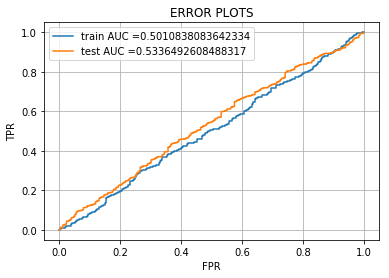

In [54]:
train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [55]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshold, fpr, tpr):
    
    tr_threshold = threshold[np.argmax(train_tpr*(1-train_fpr))]
    te_threshold = threshold[np.argmax(test_tpr*(1-test_fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of train_tpr*(1-train_fpr)", max(train_tpr*(1-train_fpr)), "for threshold", np.round(tr_threshold,3))
    print("the maximum value of test_tpr*(1-test_tpr)", max(test_tpr*(1-test_tpr)), "for threshold", np.round(te_threshold,3))

    predictions = []
    for i in proba:
        if i>=tr_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

   


In [56]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train bow confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_threshold, train_fpr, train_fpr)))
print("Test bow confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr)))

Train bow confusion matrix
the maximum value of train_tpr*(1-train_fpr) 0.2563860141064192 for threshold 0.847
the maximum value of test_tpr*(1-test_tpr) 0.24999795334025102 for threshold 0.848
[[175 167]
 [949 953]]
Test bow confusion matrix
the maximum value of train_tpr*(1-train_fpr) 0.2563860141064192 for threshold 0.845
the maximum value of test_tpr*(1-test_tpr) 0.24999795334025102 for threshold 0.846
[[  83  169]
 [ 396 1002]]


In [57]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

the maximum value of train_tpr*(1-train_fpr) 0.2563860141064192 for threshold 0.847
the maximum value of test_tpr*(1-test_tpr) 0.24999795334025102 for threshold 0.848


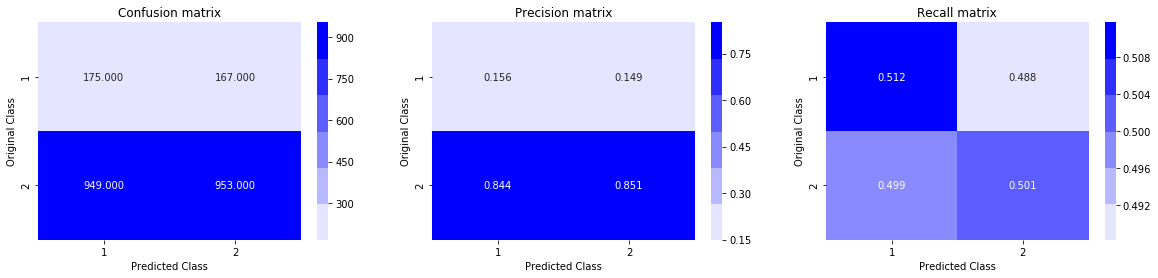

In [58]:
print("="*100)
plot_confusion_matrix(y_train, predict(y_train_pred, tr_threshold, train_fpr, train_fpr))

the maximum value of train_tpr*(1-train_fpr) 0.2563860141064192 for threshold 0.845
the maximum value of test_tpr*(1-test_tpr) 0.24999795334025102 for threshold 0.846


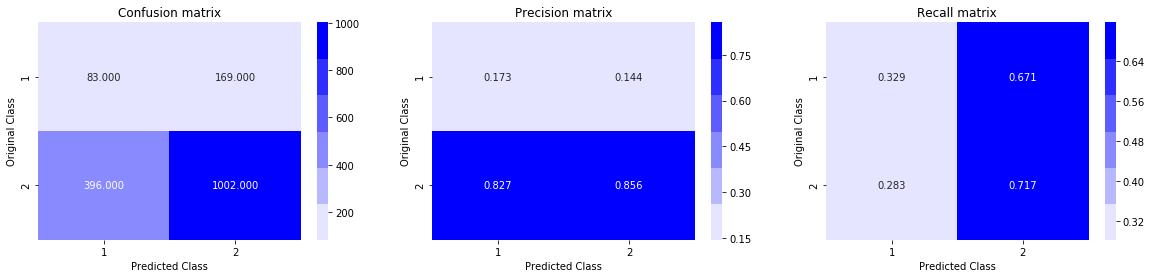

In [59]:
print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))

In [60]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 2.4.2 Applying Support Vector Machines on TFIDF,<font color='red'> SET 2</font>

In [61]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_tfidf, X_train_essay_tfidf, X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train)).tocsr()
X_cr = hstack((X_cv_title_tfidf, X_cv_essay_tfidf, X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv)).tocsr()
X_te = hstack((X_test_title_tfidf, X_test_essay_tfidf, X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 7177) (2244,)
(1106, 7177) (1106,)
(1650, 7177) (1650,)


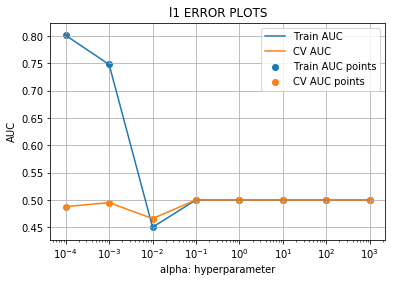

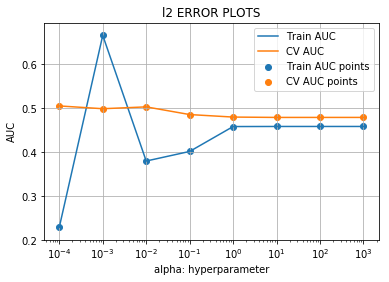

In [62]:
alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l1', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l1 ERROR PLOTS")
plt.grid()
plt.show()

print("="*100)

alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l2', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l2 ERROR PLOTS")
plt.grid()
plt.show()
    

    



In [63]:
#here we are choosing the best_k based on forloop results
best_alpha = 10**0
best_penalty = 'l2'

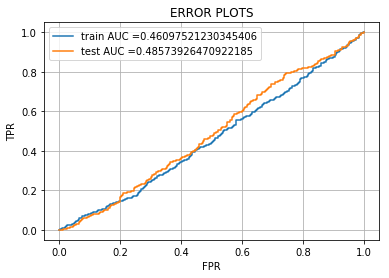

In [64]:
clf = linear_model.SGDClassifier(loss='hinge', alpha = best_alpha, penalty= best_penalty, class_weight = 'balanced')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
text_clf = calibrated_clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


preds_train = text_clf.predict_proba(X_tr)    
preds_test = text_clf.predict_proba(X_te)

y_train_pred = preds_train[:,1]
y_test_pred = preds_test[:,1]

train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


the maximum value of train_tpr*(1-train_fpr) 0.23220863234145653 for threshold 0.848
the maximum value of test_tpr*(1-test_tpr) 0.24997492841807528 for threshold 0.849


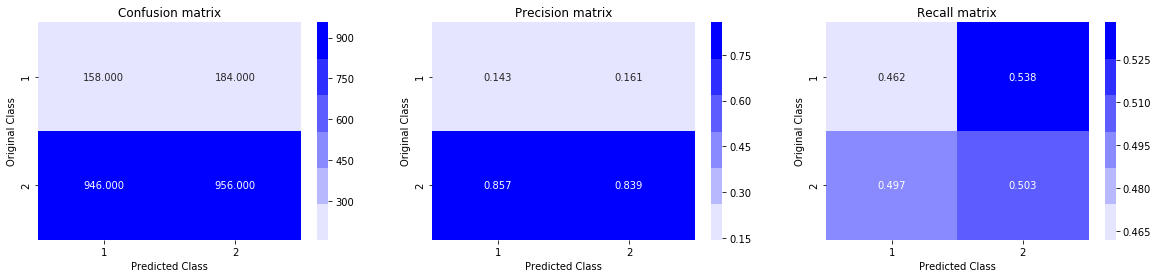

In [65]:
print("="*100)
plot_confusion_matrix(y_train, predict(y_train_pred, tr_threshold, train_fpr, train_fpr))

the maximum value of train_tpr*(1-train_fpr) 0.23220863234145653 for threshold 0.846
the maximum value of test_tpr*(1-test_tpr) 0.24997492841807528 for threshold 0.848


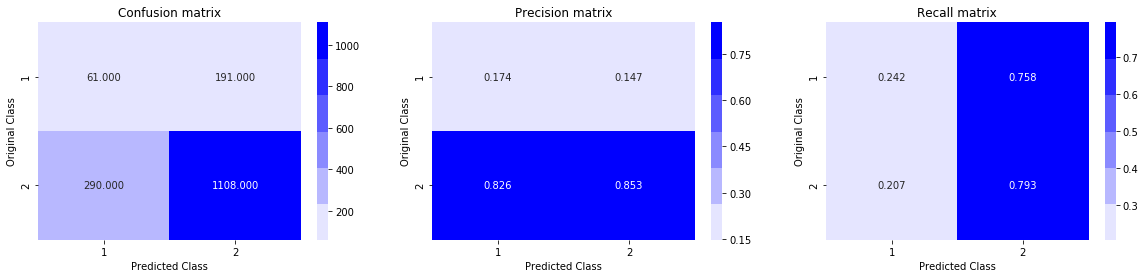

In [66]:
print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))

### 2.4.3 Applying Support Vector Machines on AVG W2V,<font color='red'> SET 3</font>

In [67]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_avg_w2v, X_train_essay_avg_w2v, X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train)).tocsr()
X_cr = hstack((X_cv_title_avg_w2v, X_cv_essay_avg_w2v, X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv)).tocsr()
X_te = hstack((X_test_title_avg_w2v, X_test_essay_avg_w2v, X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 97) (2244,)
(1106, 97) (1106,)
(1650, 97) (1650,)


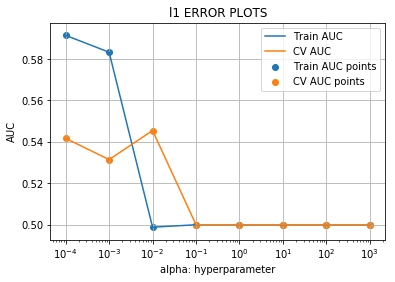

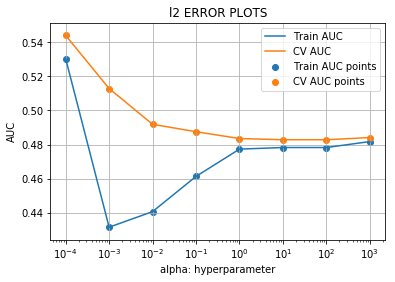

In [68]:
alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l1', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l1 ERROR PLOTS")
plt.grid()
plt.show()

print("="*100)

alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l2', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l2 ERROR PLOTS")
plt.grid()
plt.show()
    

    



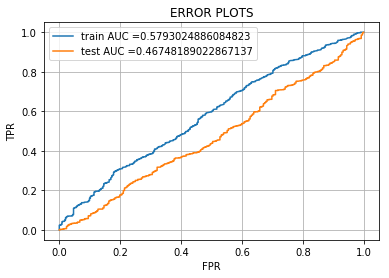

the maximum value of train_tpr*(1-train_fpr) 0.30691454363212617 for threshold 0.847
the maximum value of test_tpr*(1-test_tpr) 0.24999181336100418 for threshold 0.849


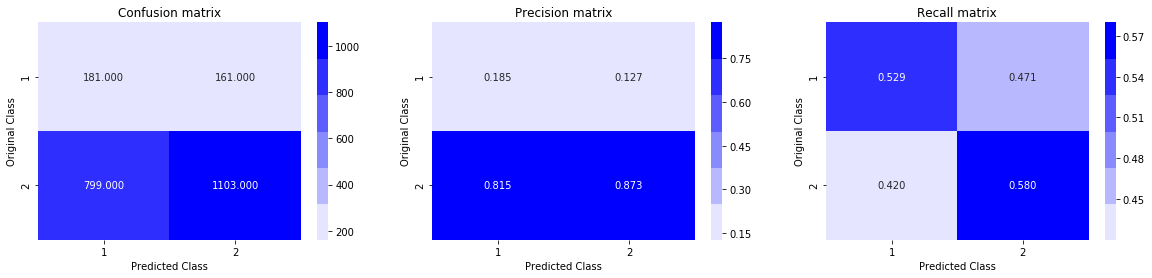

the maximum value of train_tpr*(1-train_fpr) 0.30691454363212617 for threshold 0.844
the maximum value of test_tpr*(1-test_tpr) 0.24999181336100418 for threshold 0.847


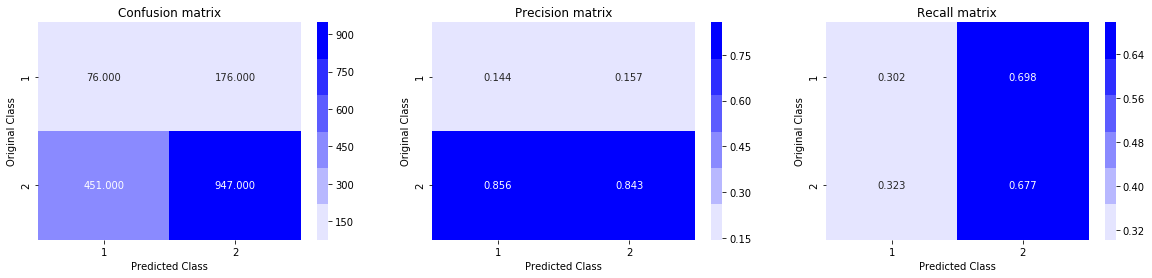

In [69]:
#here we are choosing the best_k based on forloop results
best_alpha = 10**-3
best_penalty = 'l1'

clf = linear_model.SGDClassifier(loss='hinge', alpha = best_alpha, penalty= best_penalty, class_weight = 'balanced')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
text_clf = calibrated_clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


preds_train = text_clf.predict_proba(X_tr)    
preds_test = text_clf.predict_proba(X_te)

y_train_pred = preds_train[:,1]
y_test_pred = preds_test[:,1]

train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


print("="*100)
plot_confusion_matrix(y_train, predict(y_train_pred, tr_threshold, train_fpr, train_fpr))

print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))

### 2.4.4 Applying Support Vector Machines on TFIDF W2V,<font color='red'> SET 4</font>

In [70]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_tfidf_w2v, X_train_essay_tfidf_w2v, X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train)).tocsr()
X_cr = hstack((X_cv_title_tfidf_w2v, X_cv_essay_tfidf_w2v, X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv)).tocsr()
X_te = hstack((X_test_title_tfidf_w2v, X_test_essay_tfidf_w2v, X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 97) (2244,)
(1106, 97) (1106,)
(1650, 97) (1650,)


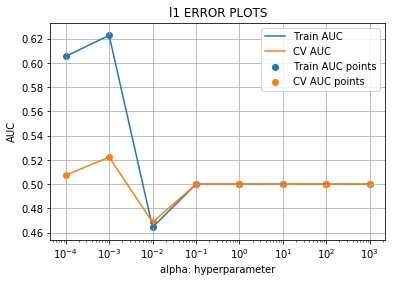

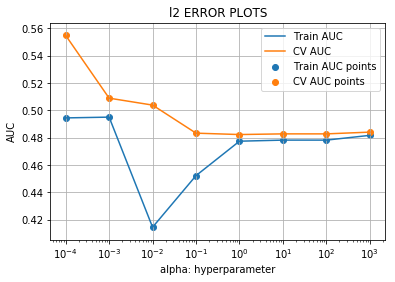

In [71]:
alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l1', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l1 ERROR PLOTS")
plt.grid()
plt.show()

print("="*100)

alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l2', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l2 ERROR PLOTS")
plt.grid()
plt.show()
    

    



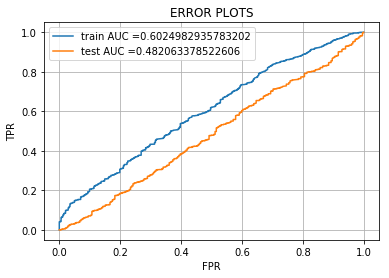

the maximum value of train_tpr*(1-train_fpr) 0.324888851993285 for threshold 0.846
the maximum value of test_tpr*(1-test_tpr) 0.24999795334025104 for threshold 0.847


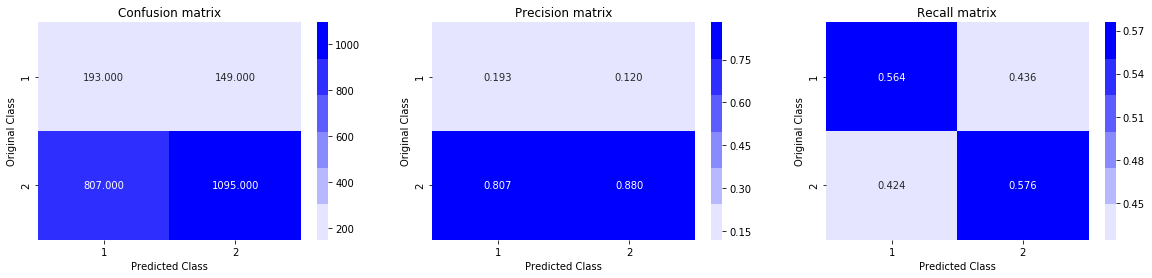

the maximum value of train_tpr*(1-train_fpr) 0.324888851993285 for threshold 0.845
the maximum value of test_tpr*(1-test_tpr) 0.24999795334025104 for threshold 0.846


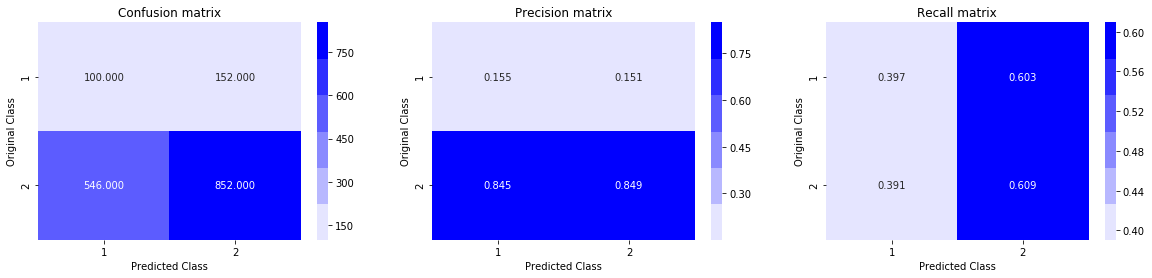

In [72]:
#here we are choosing the best_k based on forloop results
best_alpha = 10**-4
best_penalty = 'l1'

clf = linear_model.SGDClassifier(loss='hinge', alpha = best_alpha, penalty= best_penalty, class_weight = 'balanced')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
text_clf = calibrated_clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


preds_train = text_clf.predict_proba(X_tr)    
preds_test = text_clf.predict_proba(X_te)

y_train_pred = preds_train[:,1]
y_test_pred = preds_test[:,1]

train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

print("="*100)
plot_confusion_matrix(y_train, predict(y_train_pred, tr_threshold, train_fpr, train_fpr))

print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))

# Apply Support Vector Machines on the below feature set Set 5

In [73]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train,X_train_quantity_norm,X_train_essaywords_norm ,X_train_titleno_norm,X_train_price_norm,X_train_teacherno_norm,X_train_compoundr_norm ,X_train_posr_norm, X_train_neur_norm, X_train_negr_norm)).tocsr()
X_cr = hstack((X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv,X_cv_quantity_norm,X_cv_essaywords_norm ,X_cv_titleno_norm,
               X_cv_price_norm,X_cv_teacherno_norm,X_cv_compoundr_norm ,X_cv_posr_norm, X_cv_neur_norm, X_cv_negr_norm)).tocsr()
X_te = hstack((X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test,X_test_quantity_norm,X_test_essaywords_norm ,X_test_titleno_norm,
               X_test_price_norm,X_test_teacherno_norm,X_test_compoundr_norm ,X_test_posr_norm, X_test_neur_norm, X_test_negr_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 106) (2244,)
(1106, 106) (1106,)
(1650, 106) (1650,)


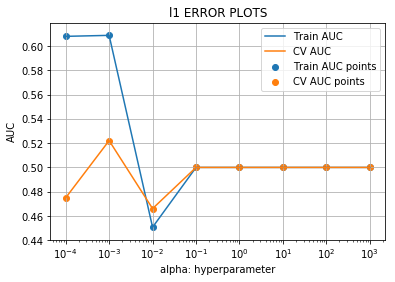

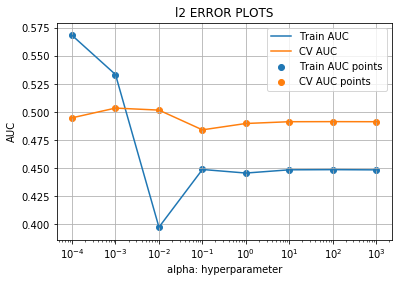

In [74]:

alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l1', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l1 ERROR PLOTS")
plt.grid()
plt.show()

print("="*100)

alpha = [10 ** x for x in range(-4,4)]
train_auc = []
cv_auc = []
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty = 'l2', class_weight = 'balanced', alpha = i)
    calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    text_clf = calibrated_clf.fit(X_tr, y_train)

    preds_train = text_clf.predict_proba(X_tr)    
    preds_test = text_clf.predict_proba(X_cr)

    y_train_pred = preds_train[:,1]
    y_cv_pred = preds_test[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("l2 ERROR PLOTS")
plt.grid()
plt.show()
    

    



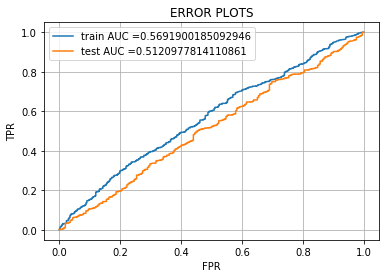

the maximum value of train_tpr*(1-train_fpr) 0.30467467301271056 for threshold 0.846
the maximum value of test_tpr*(1-test_tpr) 0.24999948833506275 for threshold 0.85


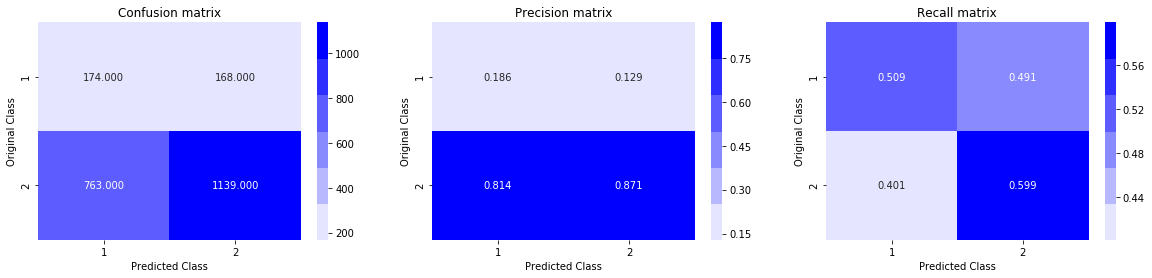

the maximum value of train_tpr*(1-train_fpr) 0.30467467301271056 for threshold 0.844
the maximum value of test_tpr*(1-test_tpr) 0.24999948833506275 for threshold 0.848


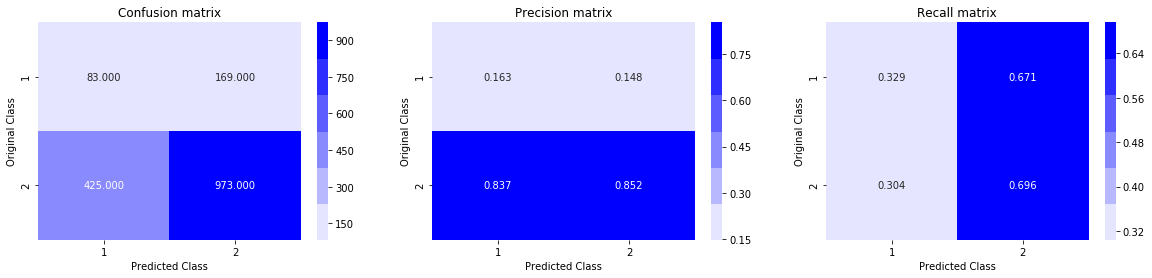

In [75]:
#here we are choosing the best_k based on forloop results
best_alpha = 10**-3
best_penalty = 'l2'

clf = linear_model.SGDClassifier(loss='hinge', alpha = best_alpha, penalty= best_penalty, class_weight = 'balanced')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
text_clf = calibrated_clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


preds_train = text_clf.predict_proba(X_tr)    
preds_test = text_clf.predict_proba(X_te)

y_train_pred = preds_train[:,1]
y_test_pred = preds_test[:,1]

train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

print("="*100)
plot_confusion_matrix(y_train, predict(y_train_pred, tr_threshold, train_fpr, train_fpr))

print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))

<h2>2.6 Pretty Table </h2>

In [76]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "Regularizer", "AUC"]

x.add_row(["BOW", "SVM", 10**-3, "l2", 0.56])
x.add_row(["TFIDF", "SVM", 10**1, "l1", 0.50])
x.add_row(["AVG W2V", "SVM", 10**-1, "l2",0.49])
x.add_row(["TFIDF-W2V", "SVM", 10**-4, "l2",0.49])
x.add_row(["Set 5", "SVM", 10**-1, "l1",0.50])


print(x)

+------------+-------+----------------+-------------+------+
| Vectorizer | Model | Hyperparameter | Regularizer | AUC  |
+------------+-------+----------------+-------------+------+
|    BOW     |  SVM  |     0.001      |      l2     | 0.56 |
|   TFIDF    |  SVM  |       10       |      l1     | 0.5  |
|  AVG W2V   |  SVM  |      0.1       |      l2     | 0.49 |
| TFIDF-W2V  |  SVM  |     0.0001     |      l2     | 0.49 |
|   Set 5    |  SVM  |      0.1       |      l1     | 0.5  |
+------------+-------+----------------+-------------+------+


<h1>3. Conclusions</h1>

1. The SVM model on BOW vectorized data gives the best AUC.
2. All the models can be seen close to a random model.